# Predictive Modeling & Bayesian Methods — Interactive Lab

**Names**: Althea Grace Concha, George Emanuel Cruz
**Course / Section**: Principles of Big Data · 3DSA  
**Instructor**: *A. C. Gernale*

## How to use this notebook
* **Markdown cells** explain theory and guidelines.  
* **Python cells** (`python …`) are fully runnable—edit or re-run as you wish.  
* Plots and print-outs appear immediately beneath the code.

## 1 · The Prediction Task

In supervised learning we learn a mapping **features `X` → target `y`**.

| Task | Target | Typical Metrics |
|------|--------|-----------------|
| **Classification** | Categorical | Accuracy · Precision · Recall · F₁ · ROC-AUC |
| **Regression**     | Continuous  | MAE · RMSE ·  R² |

**Guiding questions**

1. *Which variables carry the most predictive signal?*  
2. *How do we measure performance without leaking future information?*

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

X, y = load_breast_cancer(return_X_y=True)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42)

clf = LogisticRegression(max_iter=10_000).fit(X_tr, y_tr)
print("Accuracy :", accuracy_score(y_te, clf.predict(X_te)))
print("ROC-AUC  :", roc_auc_score(y_te, clf.predict_proba(X_te)[:, 1]))

Accuracy : 0.965034965034965
ROC-AUC  : 0.9977111943404078


## 2 · Statistical (Bayesian) Classification

Bayes’ theorem updates our belief that an example belongs to class $C_k$ given evidence $\mathbf{x}$:

$$
P(C_k \mid \mathbf{x}) \;=\;
\frac{P(\mathbf{x} \mid C_k)\,P(C_k)}
     {\displaystyle\sum_j P(\mathbf{x} \mid C_j)\,P(C_j)}
$$


### 2.1 Hand-Calculation Example

*Task*: classify an e-mail as **Spam** or **Ham** using the single word feature `free`.

| Class | Prior $P(C)$ | Likelihood $P(\text{free}=1 \mid C)$ |
|-------|-------------:|--------------------------------------:|
| Spam  | 0.40 | 0.70 |
| Ham   | 0.60 | 0.05 |

What is the posterior $P(\text{Spam}\mid \text{free}=1)$?

1. Joint for Spam = 0.70 × 0.40 = 0.28  
2. Joint for Ham  = 0.05 × 0.60 = 0.03  
3. Evidence       = 0.28 + 0.03 = 0.31  
4. Posterior      = 0.28 ÷ 0.31 ≈ **0.903**

➡ Roughly **90 %** of mails containing *free* are spam under these assumptions.

In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=0)

nb = GaussianNB().fit(X_tr, y_tr)
print("Test accuracy:", nb.score(X_te, y_te))
# try: nb.predict_proba(X_te[:5])

Test accuracy: 0.9666666666666667


## 3 · Bayesian Networks (BNs)

A BN is a directed acyclic graph (DAG):

* **Nodes** = random variables.  
* **Edges** = conditional dependencies.

The joint pdf factorises as  
$$
P(X_1,\dots,X_n)=\prod_{i=1}^{n} P\bigl(X_i \;\big|\; \text{Parents}(X_i)\bigr).
$$

Model valid? True


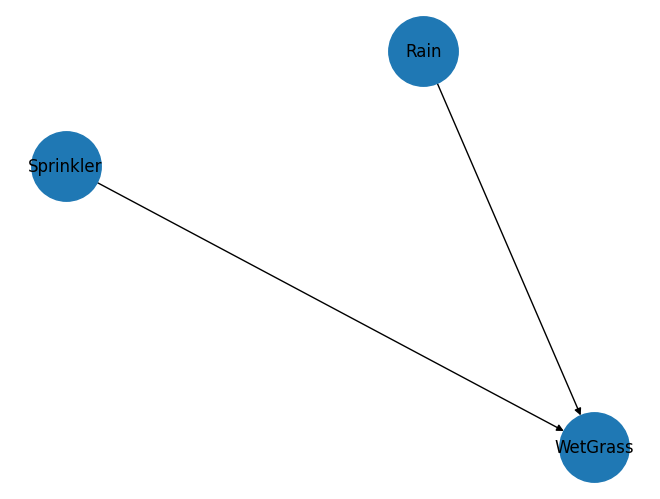

P(Rain=1 | WetGrass=1):
 +---------+-------------+
| Rain    |   phi(Rain) |
+=========+=============+
| Rain(0) |      0.6061 |
+---------+-------------+
| Rain(1) |      0.3939 |
+---------+-------------+


In [3]:
import networkx as nx, matplotlib.pyplot as plt
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

# Structure: Rain → WetGrass ← Sprinkler
bn = DiscreteBayesianNetwork([("Rain", "WetGrass"), ("Sprinkler", "WetGrass")])

# CPDs
cpd_rain = TabularCPD("Rain", 2, [[0.8], [0.2]])
cpd_spr  = TabularCPD("Sprinkler", 2, [[0.6], [0.4]])
cpd_wet  = TabularCPD("WetGrass", 2,
                      [[1, .1, .1, .01],
                       [0, .9, .9, .99]],
                      evidence=["Rain", "Sprinkler"], evidence_card=[2, 2])

bn.add_cpds(cpd_rain, cpd_spr, cpd_wet)
print("Model valid?", bn.check_model())

# Visualise
G = nx.DiGraph(bn.edges)
nx.draw(G, with_labels=True, node_size=2500); plt.show()

# Inference
infer = VariableElimination(bn)
print("P(Rain=1 | WetGrass=1):\n", infer.query(["Rain"], evidence={"WetGrass": 1}))

## 4 · Instance-Based Methods — *k*-Nearest Neighbors

1. Store the entire training set.  
2. To classify a new point, locate its *k* closest neighbors.  
3. **Vote** (classification) or **average** (regression) their targets.

*Pros*: Zero training time, flexible decision boundary.  
*Cons*: Memory heavy, slow prediction, sensitive to scaling.

In [4]:
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X, y = load_digits(return_X_y=True)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5).fit(X_tr, y_tr)
print(classification_report(y_te, knn.predict(X_te), zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        33
           3       1.00      1.00      1.00        34
           4       0.98      1.00      0.99        46
           5       0.98      0.96      0.97        47
           6       0.97      1.00      0.99        35
           7       1.00      0.97      0.99        34
           8       1.00      1.00      1.00        30
           9       0.95      0.95      0.95        40

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



## 5 · Case-Based Assignment (Pairs)

**Scenario**: You are junior data scientists at a fintech firm fighting loan default.

### Deliverables
1. **EDA** of the supplied loan CSV.  
2. **Three models**  
   * Gaussian Naïve Bayes  
   * Custom 5- 8-node Bayesian Network  
   * Tuned k-NN  
3. 5-fold stratified CV — report Accuracy, ROC-AUC, *plus* calibration plots.  
4. ≤ 3-page reflective write-up: best model & *why*, scaling impact on k-NN, realism of assumptions.  
5. Upload `loan_prediction.ipynb`, `report.pdf`, and `loan_dataset.csv`.

**Deadline**: one week from release.

In [5]:
# !pip install -q scikit-learn pgmpy networkx matplotlib seaborn pandas
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (accuracy_score, roc_auc_score, roc_curve,
                             classification_report)
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import networkx as nx
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

In [6]:
# Synthetic dataset (n = 1000)
rng = np.random.default_rng(42)
n = 1000
age = rng.integers(21, 70, n)
annual_income = np.clip(rng.normal(40_000, 15_000, n), 10_000, 200_000).round()
loan_amount = np.clip(rng.normal(15_000, 8_000, n), 1_000, 50_000).round()
term_months = rng.choice([12, 24, 36, 48, 60], n)
interest_rate = np.clip(rng.normal(10, 4, n), 1, 35).round(2)
credit_score = np.clip(rng.normal(680, 70, n), 300, 850).round()
employment_length = rng.integers(0, 41, n)
dti = np.clip((loan_amount / np.maximum(annual_income, 1))
              + rng.normal(0.05, 0.05, n), 0, 1).round(2)

logit = (-0.005*credit_score - 0.00002*annual_income + 0.00006*loan_amount
         + 0.15*interest_rate + 2.0*dti - 0.02*employment_length
         + rng.normal(0, 0.5, n))
prob_default = 1 / (1 + np.exp(-logit))
default_flag = rng.random(n) < prob_default

df = pd.DataFrame({
    "age": age, "annual_income": annual_income,
    "loan_amount": loan_amount, "term_months": term_months,
    "interest_rate": interest_rate, "credit_score": credit_score,
    "employment_length": employment_length, "dti": dti,
    "default": default_flag.astype(int)
})
df.to_csv("loan_data.csv", index=False)
df.head()

,age,annual_income,loan_amount,term_months,interest_rate,credit_score,employment_length,dti,default
0,25,61498.0,19507.0,60,7.27,607.0,30,0.27,0
1,58,41373.0,15917.0,36,18.13,637.0,38,0.50,0
2,53,48712.0,17640.0,12,9.87,608.0,34,0.44,0
3,42,39148.0,21221.0,48,14.11,571.0,11,0.64,1
4,42,37444.0,8524.0,12,9.79,695.0,33,0.31,1


## 1 · Exploratory Data Analysis (EDA)
We will:

1. Inspect data types & basic stats.  
2. Build a compact **data dictionary**.  
3. Visualise distributions (univariate), relationships (bivariate), and the correlation matrix.  
4. Summarise key risk insights.

In [7]:
df.info()
df.describe(include="all").T
print("\nMissing values\n", df.isna().sum())
print("\nClass balance\n", df["default"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1000 non-null   int64  
 1   annual_income      1000 non-null   float64
 2   loan_amount        1000 non-null   float64
 3   term_months        1000 non-null   int32  
 4   interest_rate      1000 non-null   float64
 5   credit_score       1000 non-null   float64
 6   employment_length  1000 non-null   int64  
 7   dti                1000 non-null   float64
 8   default            1000 non-null   int32  
dtypes: float64(5), int32(2), int64(2)
memory usage: 62.6 KB

Missing values
 age                  0
annual_income        0
loan_amount          0
term_months          0
interest_rate        0
credit_score         0
employment_length    0
dti                  0
default              0
dtype: int64

Class balance
 default
0    718
1    282
Name: count, dtype: int64


| Column | Description | Type |
| ------ | ----------- | ---- |
| `age` | Borrower age | int |
| `annual_income` | Annual salary (USD) | float |
| `loan_amount` | Amount requested (USD) | float |
| `term_months` | Loan tenor | int |
| `interest_rate` | Annual rate (%) | float |
| `credit_score` | FICO-like score | float |
| `employment_length` | Years employed | int |
| `dti` | Debt-to-Income ratio | float |
| `default` | **Target** (1 = default) | int |

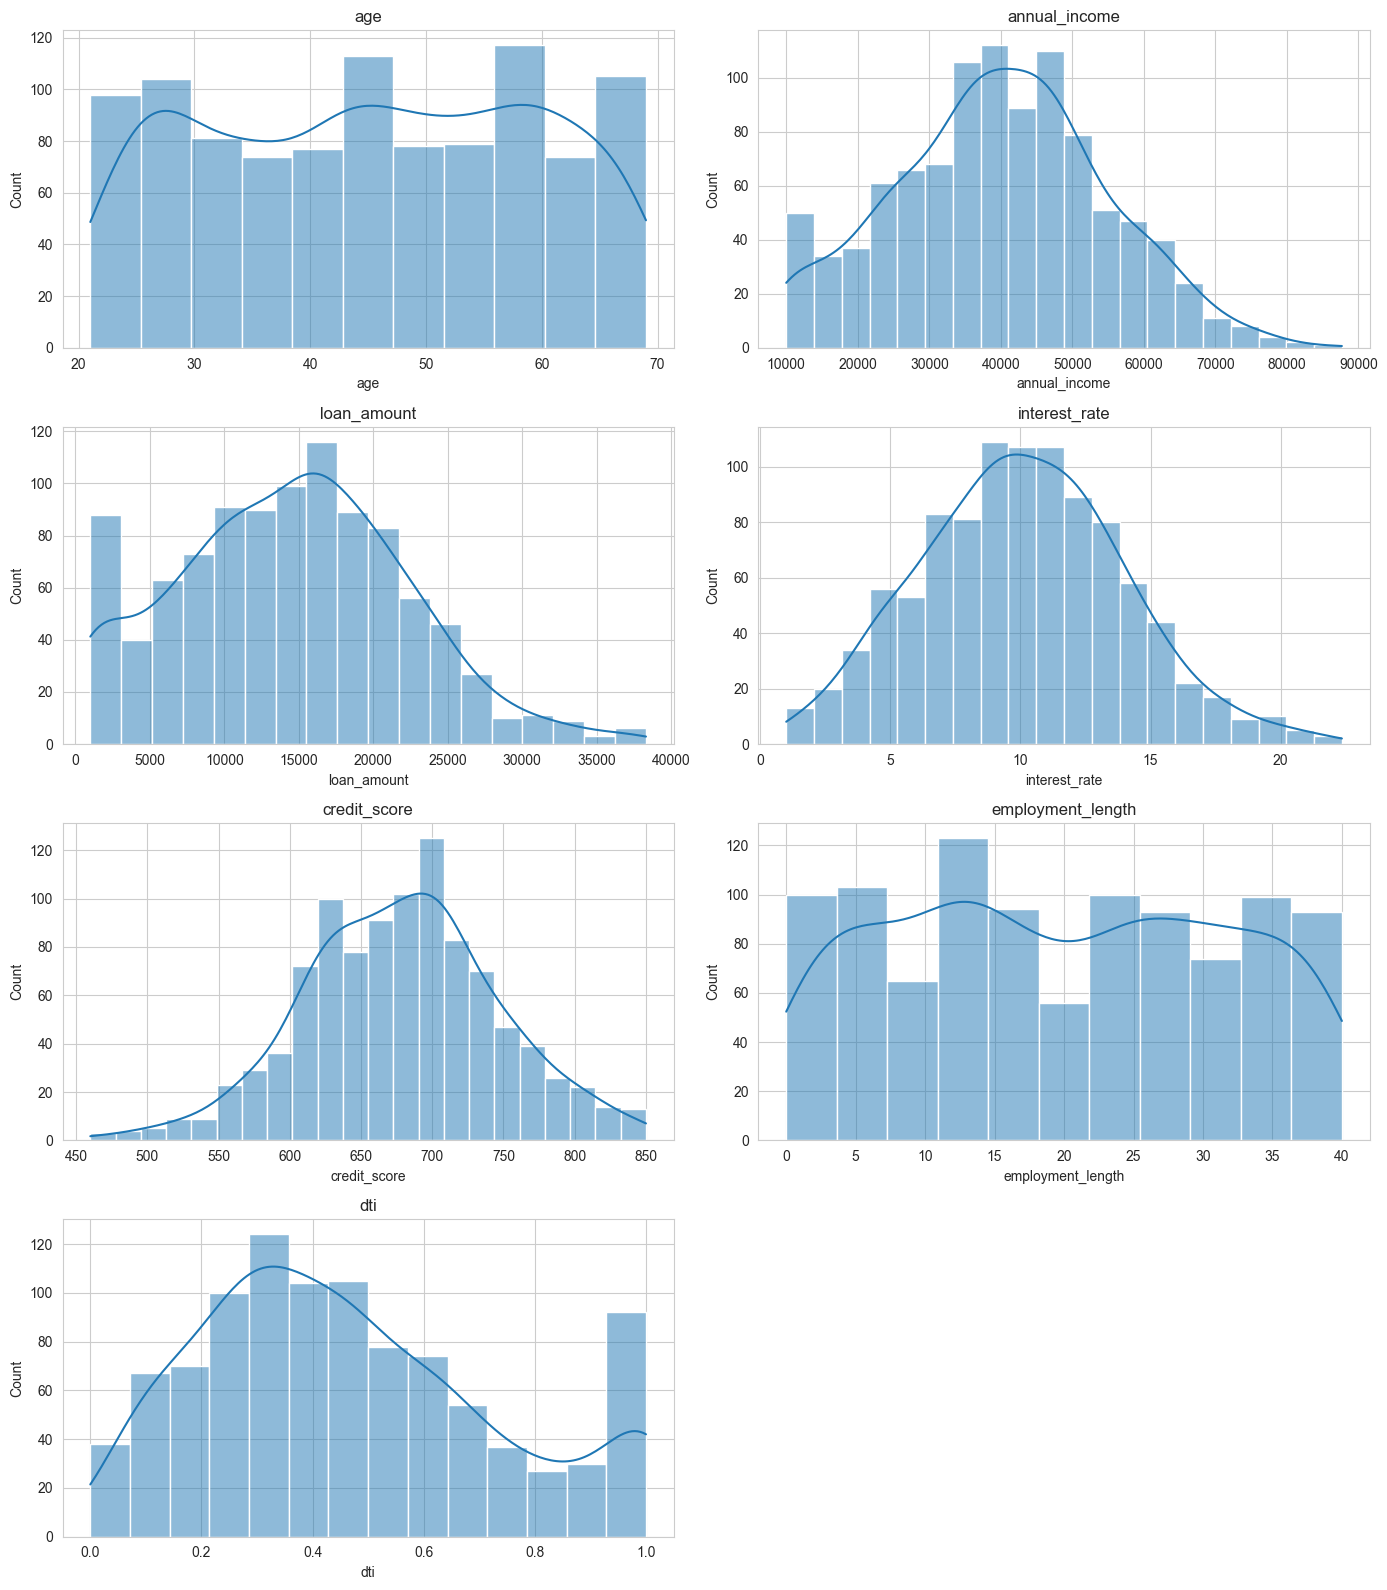

In [8]:
sns.set_style("whitegrid")

# --- build an 8-panel grid ---
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()               #  → 1-D list of Axes (length = 8)

numeric_cols = ['age', 'annual_income', 'loan_amount', 'interest_rate',
                'credit_score', 'employment_length', 'dti']

# --- plot the first 7 panels ---
for ax, col in zip(axes, numeric_cols):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(col)

# --- drop the unused 8th panel ---
fig.delaxes(axes[-1])               # now axes[-1] is a single Axes
plt.tight_layout()
plt.show()

**Key take-aways**

* Income, loan amount, and DTI are right-skewed — indicative of a long-tail of higher-risk applicants.  
* Credit scores cluster around 650 – 700, implying screening before approval.  
* Age and employment length appear roughly uniform → weak standalone predictors.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


C:\Users\emang\AppData\Local\Temp\ipykernel_12196\2166065767.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="default", data=df, palette="Set2")
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


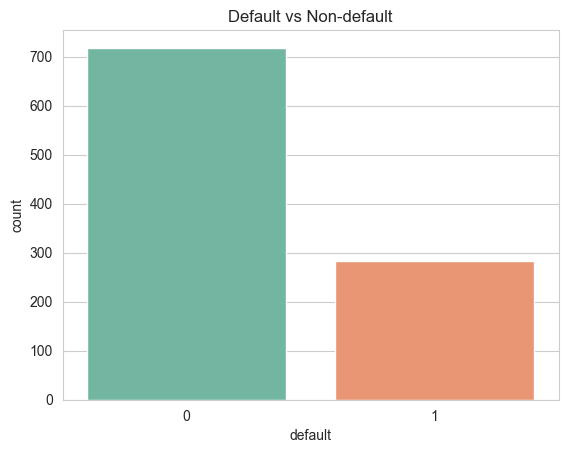

In [9]:
sns.countplot(x="default", data=df, palette="Set2")
plt.title("Default vs Non-default"); plt.show()

About **28 %** of records are defaults — a non-trivial minority that warrants stratified CV and care with class imbalance.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


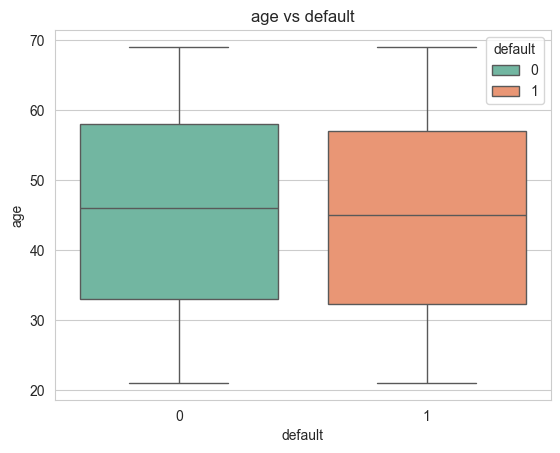

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


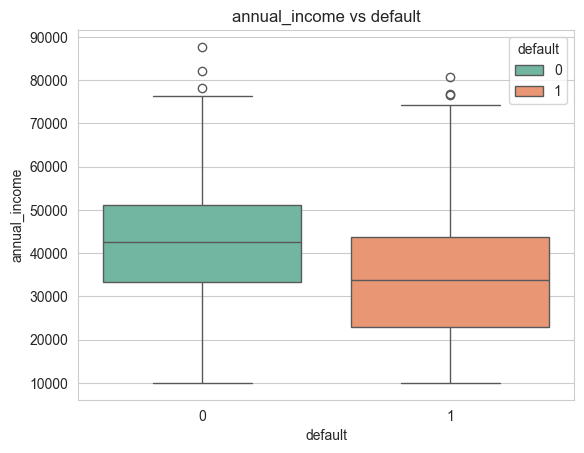

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


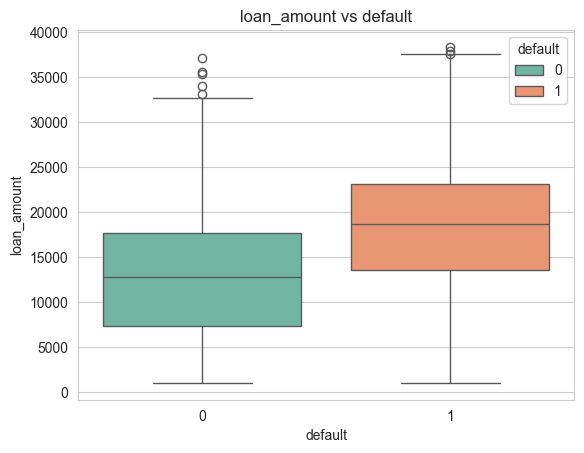

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


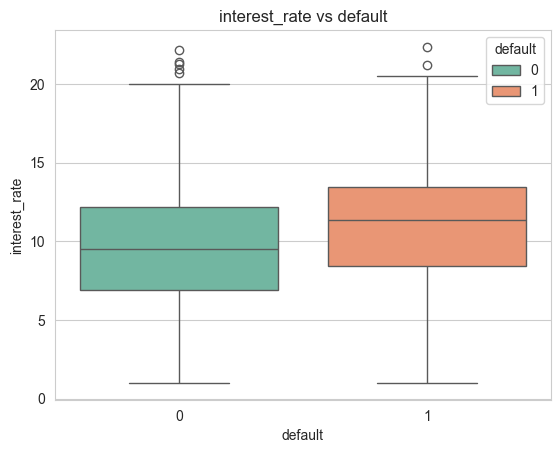

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


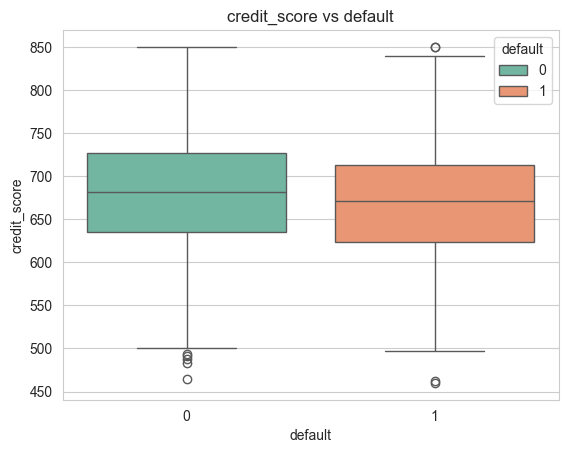

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


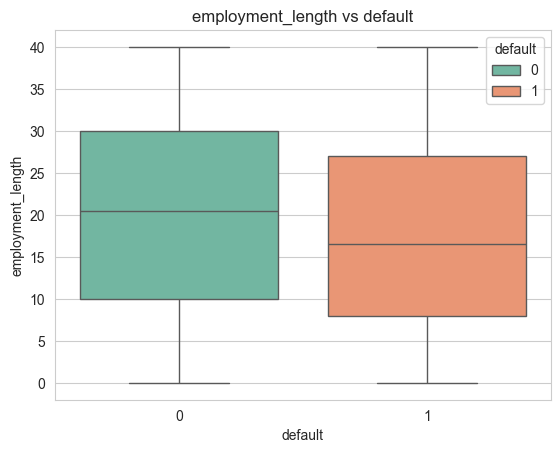

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


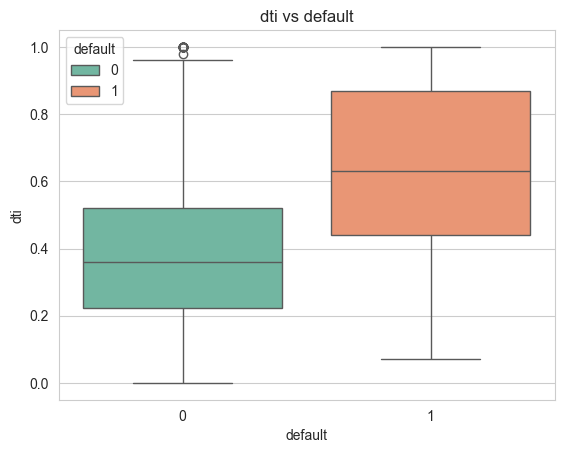

In [10]:
palette = {0: "#66c2a5", 1: "#fc8d62"}
for col in ['age', 'annual_income', 'loan_amount', 'interest_rate',
            'credit_score', 'employment_length', 'dti']:
    sns.boxplot(x="default", y=col, hue="default", data=df, palette=palette)
    plt.title(f"{col} vs default"); plt.show()

### Insights
**1. Age vs Default**<br>
Instead of loan-repaying borrowers, the default group is mainly made up of people from younger demographics.  Given that the results raise the possibility that those with less financial stability and experience tend to be younger, it is beneficial for loan risk assessment to take borrowers' ages into account.

**2. Annual Income vs Default**<br>
Individuals with lower yearly incomes are more likely to stop making payments on their debts. These borrowers have little capacity to manage debt or withstand financial shocks. Higher incomes provide a stable financial situation, which guards against loan nonpayment.

**3. Credit Score vs Default**<br>
Poor credit scores are continuously displayed throughout the records of borrowers who default on their loans. The credit score's predictions of financial reliability align with its core purpose. Lenders must continue to use credit scores in their risk assessments.

**4. Loan Amount vs Default**<br>
People who default on loan payments typically obtain more significant borrowing amounts. Higher loans often lead borrowers to handle more significant payment amounts, increasing the possibility of late payments. The assessment of loan size requires a comparison between the borrower's income and debt responsibilities.

**5. Interest Rate vs Default**<br>
People who default on their loan payments typically face higher interest rates. The pricing system for credit risks appears to determine higher rates but simultaneously adds stress to borrowers' finances. When borrowers face excessive interest rates, conditions for their eventual default are occasionally created.

**6. Employment Length vs Default**<br>
Defaulters usually have less time in their current or previous jobs. Employees' job stability evaluates their ability to handle loans for prolonged financial responsibilities. A person's employment stability helps evaluate their potential to meet repayment obligations.

**7. Debt-to-Income Ratio (DTI) vs Default**<br>
The average DTI ratio exceeds significantly among the default population. A higher proportion of their income gets used to pay off existing debts among these borrowers. The condition of elevated risk coupled with debt overextension reveals itself through high DTI ratios.

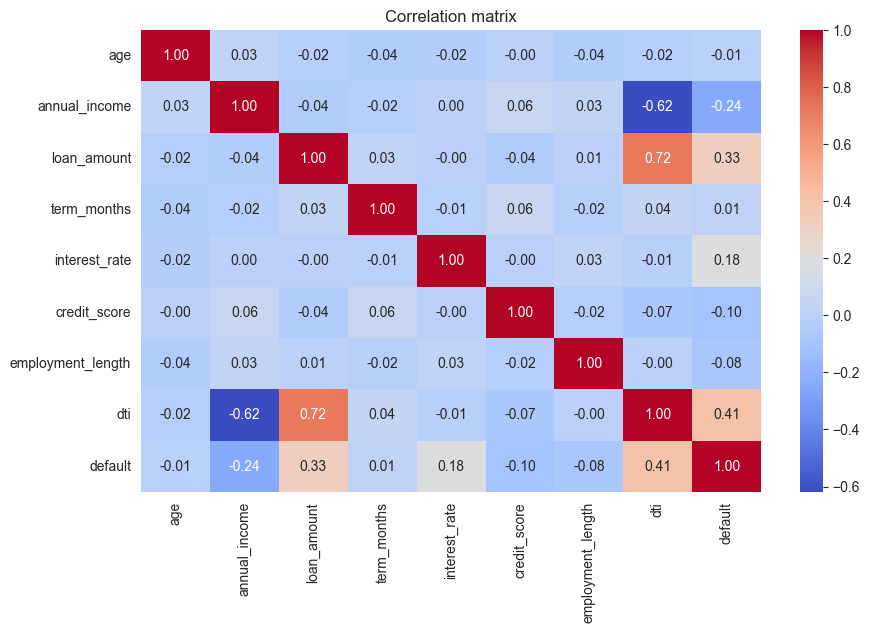

In [11]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation matrix"); plt.show()

*Highest positive* with default: **DTI (0.41)**, *loan_amount (0.33)*.  
Negative: **annual_income (−0.24)** — richer borrowers default less.

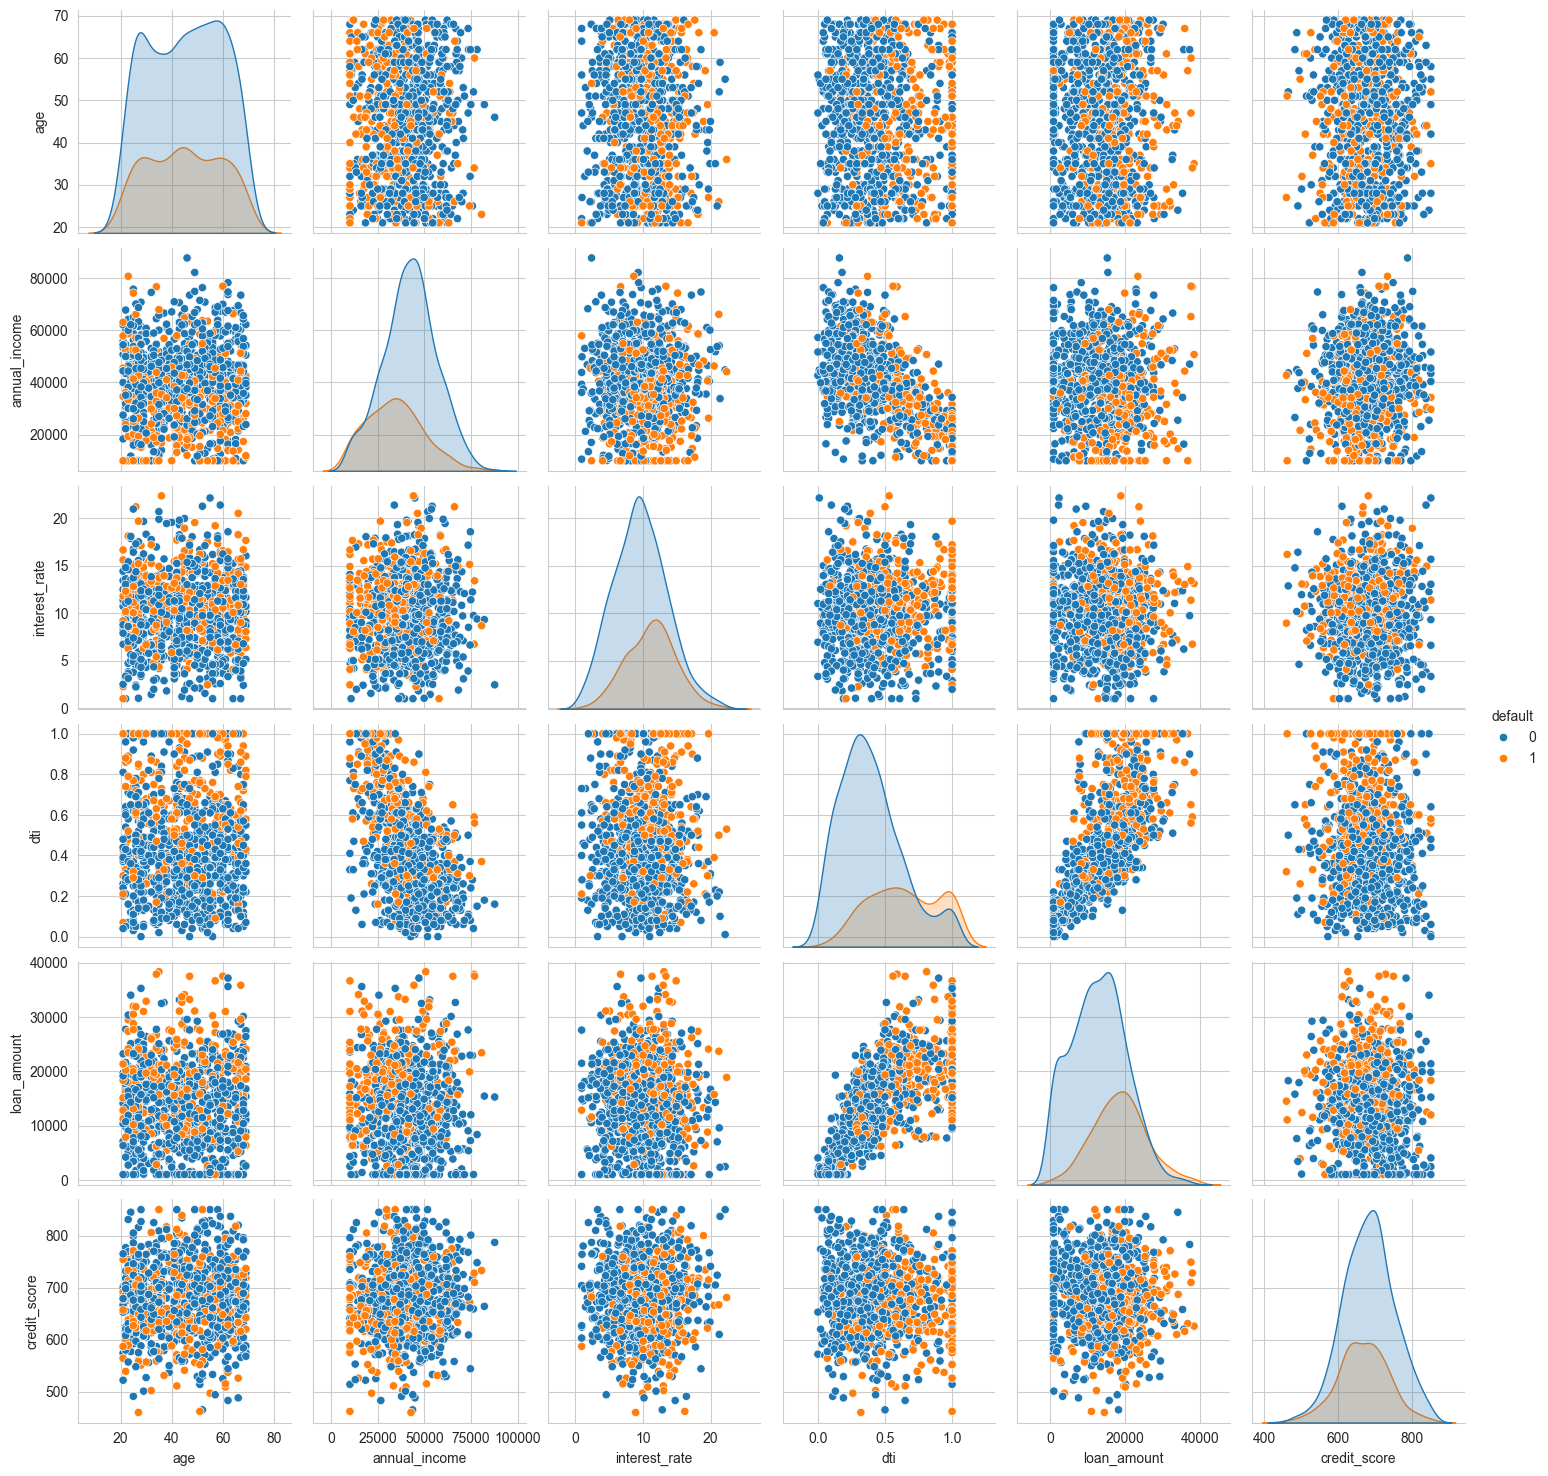

In [12]:
sns.pairplot(df[['age', 'annual_income', 'interest_rate', 'dti', 
                 'loan_amount', 'credit_score', 'default']], hue='default')

### Insights
**1. Debt-to-Income Ratio (dti):**<br>
People who have high debt-to-income ratios demonstrate more regular default behavior. Most of their monthly earnings currently service debt obligations, thus decreasing their capability to service new loans. Organizations that conduct DTI monitoring alongside strict limit enforcement will experience lower default risk.

**2. Credit Score:**<br>
The default rate is higher among applicants with credit scores under 600 and people with poor credit standing. The background of bad financial decisions and untrustworthy credit behavior stand behind this situation. Minimum credit score criteria lead to decreased risk factors for financial institutions.

**3. Loan Amount:**<br>
A higher number of default cases occur when borrowers receive large loans, likely because higher loan amounts create excessive financial problems. The combination of large loan amounts and borrowers having either low or high DTI makes loans challenging. Laboratories should implement total loan limits based on a borrower's income level.

**4. Interest Rate:**<br>
The data from interest rates fails to divide borrowers who default from people who do not distinctly. The data shows that interest rate serves poorly as an isolated element in predicting default occurrences. The measurement of this factor needs to proceed together with other factors like data and credit score ratings.

**5. Age:**<br>
Most borrowers fall within the 25–45-year age range and defaults appear in all age groups according to the age distribution. Borrower age does not create a substantial link to default risk levels. The metrics measuring financial behavior provide better predictive value than age does.

**6. Annual Income:**<br>
People with default and no default backgrounds have all income levels in common, showing that income does not serve as a substantial predictive variable. High income does not guarantee loan repayment when DTI levels remain high. The evaluation process needs to focus on how borrowers manage their debt relative to their income.

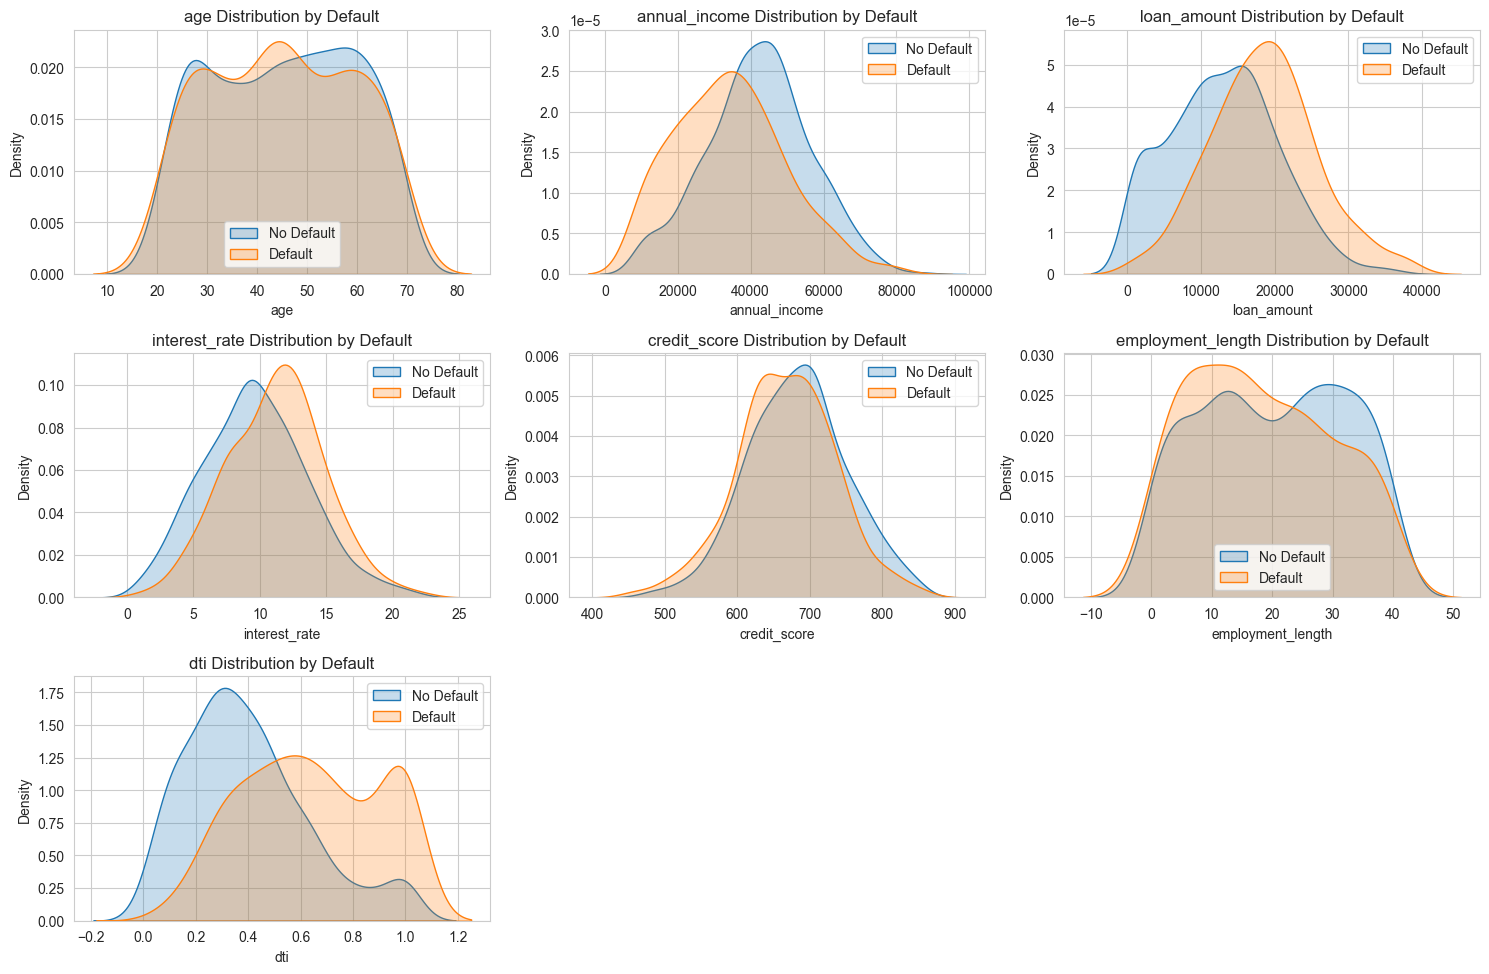

In [13]:
columns = ['age', 'annual_income', 'loan_amount', 'interest_rate', 'credit_score', 'employment_length', 'dti']
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns, 1):
    plt.subplot(3, 3, i)  
    sns.kdeplot(data=df[df['default'] == 0][column], label='No Default', fill=True)
    sns.kdeplot(data=df[df['default'] == 1][column], label='Default', fill=True)
    plt.title(f'{column} Distribution by Default')  
    plt.xlabel(column)  
    plt.ylabel('Density')  
    plt.legend() 
plt.tight_layout()
plt.show()

### Insights
**1. Age:**<br>
Age does not generate apparent differences between defaulters and non-defaulters, but defaulter rates show a strong peak between ages 30 and 40. The cluster of default risk appears during the beginning of an individual's career, which relates to financial challenges and career shifts. A non-linear representation of age demonstrates potential predictive power when used as a data segment.

**2. Annual Income:**<br>
After reaching 50,000 USD, income professionals show accelerated default reductions in the distribution, demonstrating reduced default risk levels in that income bracket. The drop in risk becomes more pronounced when the income crosses a specific threshold point. Whether income exceeds $50k represents a better prediction metric than using income as a simple continuous variable.

**3. Loan Amount:**<br>
The highest default rate is $20,000, and the widened right section indicates that the risk increases unevenly based on the loan amount. Borrowers who take moderate-to-large loans when they do not have sufficient income or credit support tend to default on payments. Dividing loans into small, medium, and large categories would help to develop better risk assessment profiles.

**4. Interest Rate:**<br>
The defaulter population forms its highest concentration at the location where the non-defaulter population starts reducing between the 11–13% interest rate point. Insufficient creditworthiness may start to appear when interest rates exceed this crossover threshold. Apply the observed threshold point as a review trigger to investigate potential default cases more deeply.

**5. Credit Score:**<br>
Independently measured at similar rates between 620 and 700, the defaulters exhibit lower density, which indicates their creditworthiness varies more. The unanticipated irregularities in financial conduct and unstable credit profiles show themselves through this metric. The analysis benefits from including credit score variability and established patterns when credit scores change over time.

**6. Employment Length:**<br>
The defaulter distribution features an initial cluster of nearly 10 years that later falls away much faster than among non-defaulting customers. Risk reduction occurs through extended employment time and specific professional transitions, such as post-promotion phases. A single feature combining age with employment duration provides a better solution to identify the compound impact on borrower risk.

**7. Debt-to-Income Ratio (dti):**<br>
The distribution pattern of defaulters contains two clear peaks at points 0.4 and 1.0. This data pattern indicates default events split into two fundamental groups: general overextension occurs with moderate DTI, and severe financial distress leads to very high DTI. Bands of categorical risks derived from the DTI variable should help distinguish borrowers with different behavioral characteristics.

## 2 · Predictive Models
We compare:

1. Gaussian Naïve Bayes  
2. Discrete Bayesian Network  
3. Tuned k-Nearest Neighbors
– all evaluated with **5-fold stratified cross-validation**.

Fold 1 Accuracy: 0.7600, ROC-AUC: 0.8219
Fold 2 Accuracy: 0.7950, ROC-AUC: 0.7789
Fold 3 Accuracy: 0.7650, ROC-AUC: 0.7692
Fold 4 Accuracy: 0.7200, ROC-AUC: 0.7692
Fold 5 Accuracy: 0.7700, ROC-AUC: 0.7865


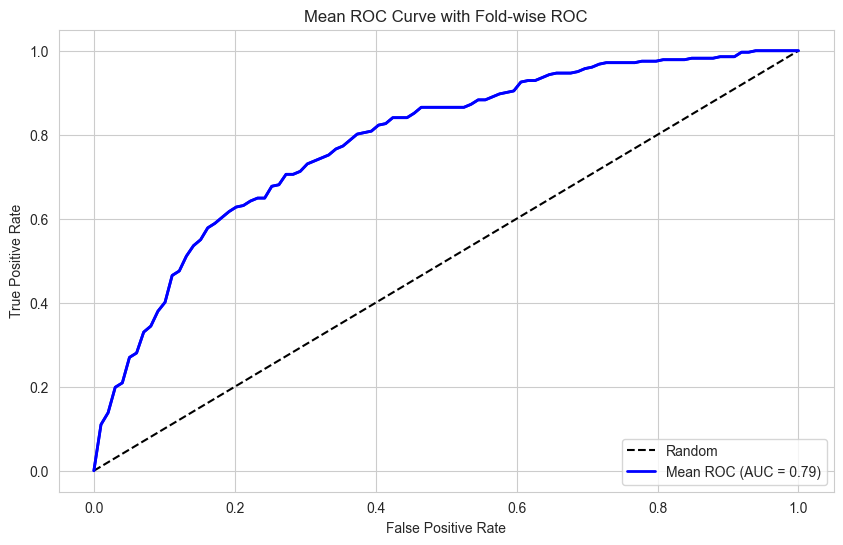

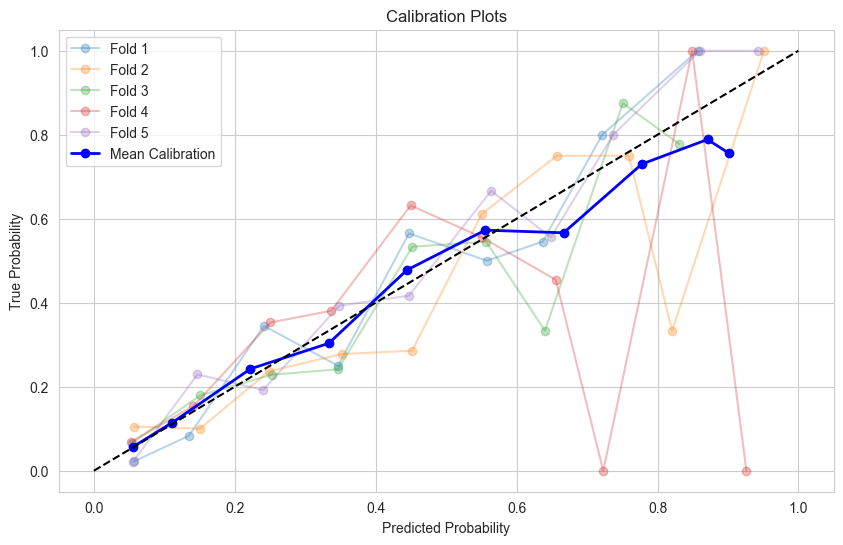


Mean Accuracy: 0.7620
Mean ROC-AUC: 0.7852


In [ ]:
X = df[['age', 'annual_income', 'loan_amount', 'interest_rate', 'credit_score', 'employment_length', 'dti']]  # Features
y = df['default']  # Set default as the target variable

model = GaussianNB()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

accuracies = []
roc_aucs = []

mean_fpr = np.linspace(0, 1, 100)
tpr_list = []

calibration_true_all = []
calibration_pred_all = []

# Start CV loop
for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the Gaussian Naive Bayes model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate accuracy and ROC-AUC
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    accuracies.append(acc)
    roc_aucs.append(roc_auc)

    print(f"Fold {fold+1} Accuracy: {acc:.4f}, ROC-AUC: {roc_auc:.4f}")

    # ROC curve for each fold
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tpr_list.append(tpr_interp)

    # Calibration
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')
    calibration_true_all.append(prob_true)
    calibration_pred_all.append(prob_pred)

# Plot Mean ROC
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
mean_tpr = np.mean(tpr_list, axis=0)
mean_auc = np.mean(roc_aucs)

plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

# Highlight mean
plt.plot(mean_fpr, mean_tpr, color='blue', lw=2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mean ROC Curve with Fold-wise ROC")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Calibration
plt.figure(figsize=(10, 6))
for fold, (true_vals, pred_vals) in enumerate(zip(calibration_true_all, calibration_pred_all)):
    plt.plot(pred_vals, true_vals, marker='o', alpha=0.3, label=f'Fold {fold+1}')

# Mean calibration
mean_cal_pred = np.mean([np.interp(np.linspace(0, 1, 10), cp, cp) for cp in calibration_pred_all], axis=0)
mean_cal_true = np.mean([np.interp(np.linspace(0, 1, 10), cp, ct) for cp, ct in zip(calibration_pred_all, calibration_true_all)], axis=0)
plt.plot(mean_cal_pred, mean_cal_true, marker='o', color='blue', label='Mean Calibration', lw=2)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Plots")
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Summary
print(f"\nMean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean ROC-AUC: {np.mean(roc_aucs):.4f}")

### Insights
The **Naive Bayes model** achieved a **76% average accuracy** level and a **0.79 average ROC-AUC** across five folds for automatically identifying defaulters versus non-defaulters. The model shows **excellent potential for reducing loan default risk** through its **ROC-AUC value**, which surpasses the **random guessing baseline of 0.5**.

The **ROC curve** confirms that the model surpasses **random classification** in every test fold, reaching around **80–90% accurate favorable detection rates** while maintaining **40–50% false positive incidents**. The model effectively detects many **defaulting customers** yet shows room for **false classifications** among those who do not default, which requires **careful tuning per a company's risk tolerance**. The **calibration plot** displays a general match between **predicted outcomes and observed results** yet demonstrates **increased variability at probabilities above 0.7**, which indicates potential improvements.

The folds demonstrated **consistent performance** through **ROC-AUC scores between 0.77 and 0.82** and **accuracy levels from 0.72 to 0.80**, which indicates **good potential for the model to predict new data**. The model demonstrates **adequate performance stability** and shows **strong-to-moderate predictive ability**, which indicates possible **implementation**, while **additional work focused on probability accuracy** will increase the model's **effectiveness**.

In [15]:
df1 = df.copy()

# Example discretization using quartiles
df1['annual_income_disc'] = pd.qcut(df1['annual_income'], q=4, labels=["low", "med_low", "med_high", "high"])
df1['loan_amount_disc'] = pd.qcut(df1['loan_amount'], q=4, labels=["low", "med_low", "med_high", "high"])
df1['dti_disc'] = pd.qcut(df1['dti'], q=4, labels=["low", "med_low", "med_high", "high"])
df1['interest_rate_disc'] = pd.qcut(df1['interest_rate'], q=4, labels=["low", "med_low", "med_high", "high"])
df1['credit_score_disc'] = pd.qcut(df1['credit_score'], q=4, labels=["poor", "fair", "good", "excellent"])
df1['employment_length_disc'] = pd.cut(df1['employment_length'], bins=[0, 2, 5, 10, 50], labels=["short", "med_short", "med_long", "long"])
df1['default'] = df1['default'].astype(str)  # Ensure it's categorical too

# Verify the changes in df1
print(df1.head())

   age  annual_income  loan_amount  term_months  interest_rate  credit_score  \
0   25        61498.0      19507.0           60           7.27         607.0   
1   58        41373.0      15917.0           36          18.13         637.0   
2   53        48712.0      17640.0           12           9.87         608.0   
3   42        39148.0      21221.0           48          14.11         571.0   
4   42        37444.0       8524.0           12           9.79         695.0   

   employment_length   dti default annual_income_disc loan_amount_disc  \
0                 30  0.27       0               high         med_high   
1                 38  0.50       0           med_high         med_high   
2                 34  0.44       0           med_high         med_high   
3                 11  0.64       1            med_low             high   
4                 33  0.31       1            med_low              low   

   dti_disc interest_rate_disc credit_score_disc employment_length_disc  


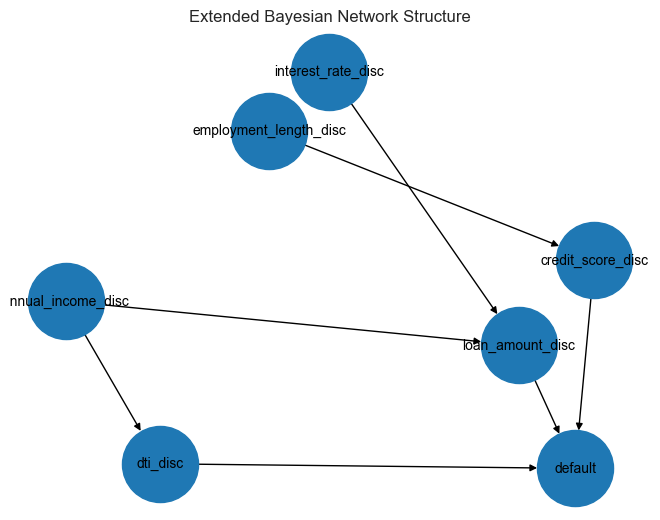

Model valid? True
P(default | loan_amount_disc=2, credit_score_disc=0, dti_disc=1):
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.9000 |
+------------+----------------+
| default(1) |         0.1000 |
+------------+----------------+


In [ ]:
# Visualize the extended Bayesian Network structure
G = nx.DiGraph([
    ('annual_income_disc', 'loan_amount_disc'),
    ('annual_income_disc', 'dti_disc'),
    ('employment_length_disc', 'credit_score_disc'),
    ('interest_rate_disc', 'loan_amount_disc'),
    ('dti_disc', 'default'),
    ('credit_score_disc', 'default'),
    ('loan_amount_disc', 'default')
])

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, font_size=10)
plt.title("Extended Bayesian Network Structure")
plt.show()

# Define the Bayesian Network structure
model = DiscreteBayesianNetwork([
    ('annual_income_disc', 'loan_amount_disc'),
    ('annual_income_disc', 'dti_disc'),
    ('employment_length_disc', 'credit_score_disc'),
    ('interest_rate_disc', 'loan_amount_disc'),
    ('dti_disc', 'default'),
    ('credit_score_disc', 'default'),
    ('loan_amount_disc', 'default')
])

# Define dummy CPDs (replace these with learned CPDs)
cpd_income = TabularCPD(variable='annual_income_disc', variable_card=3, values=[[0.3], [0.4], [0.3]])
cpd_employment = TabularCPD(variable='employment_length_disc', variable_card=3, values=[[0.2], [0.5], [0.3]])
cpd_interest = TabularCPD(variable='interest_rate_disc', variable_card=3, values=[[0.3], [0.4], [0.3]])

cpd_loan = TabularCPD(variable='loan_amount_disc', variable_card=3,
                      values=[
                          [0.3]*9,
                          [0.4]*9,
                          [0.3]*9
                      ],
                      evidence=['annual_income_disc', 'interest_rate_disc'],
                      evidence_card=[3, 3])

cpd_credit = TabularCPD(variable='credit_score_disc', variable_card=3,
                        values=[[0.3, 0.4, 0.3],
                                [0.4, 0.4, 0.2],
                                [0.3, 0.2, 0.5]],
                        evidence=['employment_length_disc'], evidence_card=[3])

cpd_dti = TabularCPD(variable='dti_disc', variable_card=3,
                     values=[[0.5, 0.3, 0.2],
                             [0.3, 0.5, 0.2],
                             [0.2, 0.2, 0.6]],
                     evidence=['annual_income_disc'], evidence_card=[3])

cpd_default = TabularCPD(variable='default', variable_card=2,
                         values=[
                             [0.9]*27,
                             [0.1]*27
                         ],
                         evidence=['loan_amount_disc', 'credit_score_disc', 'dti_disc'],
                         evidence_card=[3, 3, 3])

# Add CPDs to the model
model.add_cpds(cpd_income, cpd_employment, cpd_interest, cpd_loan, cpd_credit, cpd_dti, cpd_default)

# Validate model
print("Model valid?", model.check_model())

# Inference
inference = VariableElimination(model)

# Example query: P(default | loan_amount_disc=2, credit_score_disc=0, dti_disc=1)
result = inference.query(variables=['default'], evidence={
    'loan_amount_disc': 2,
    'credit_score_disc': 0,
    'dti_disc': 1
})
print("P(default | loan_amount_disc=2, credit_score_disc=0, dti_disc=1):")
print(result)


### Insights
TThe **Bayesian Network** shows how **borrower financial factors** link to **loan-specific features** that determine _**default risk**_. The **"default"** variable is the model's **core** since it receives direct effects from three fundamental elements: **borrower credit scores**, **loan sizes**, and **DTI value**. These **essential risk signals** quickly indicate whether people face a _**severe danger of loan default**_.

The **default risk** is affected by **various indicators** which shape the **important variables** impacting default probability. Borrowers can affect their **credit score** through their _**employment length**_, while their **interest rate** determines the **loan amount** they receive. A person's **yearly salary** directly influences the **DTI value**. The **secondary factors** affecting how risky a borrower seems create opportunities to step in early through **loan amount adjustment** or **financial help provision**.

By implementing this model, the organization identifies **risk factors** for borrower default and recognizes the **specific reasons** for default behavior. When a person possesses a **considerable loan amount** and a **poor credit rating**, they become _**immediately susceptible to default**_. The modeling system indicates **risky future patterns** among individuals who currently show _**little evidence**_ of being risky to the lender. The model enables the company to **choose loans wisely** along with **specific payment conditions**, which leads to **reduced losses** when borrowers default.

In [ ]:
# Define features and target
features = ['interest_rate_disc', 'employment_length_disc', 'credit_score_disc',
            'loan_amount_disc', 'annual_income_disc', 'dti_disc']
target = 'default'

# Drop rows with missing values
df1 = df1[features + [target]].dropna()

# Initialize cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
roc_aucs = []

# For mean ROC
mean_fpr = np.linspace(0, 1, 100)
tpr_list = []

# For calibration
calibration_true_all = []
calibration_pred_all = []

# Start CV loop
for fold, (train_idx, test_idx) in enumerate(skf.split(df1[features], df1[target])):
    train_df = df1.iloc[train_idx]
    test_df = df1.iloc[test_idx]

    # Define and train Bayesian Network
    model = DiscreteBayesianNetwork([
        ('annual_income_disc', 'loan_amount_disc'),
        ('employment_length_disc', 'credit_score_disc'),
        ('loan_amount_disc', 'default'),
        ('credit_score_disc', 'default'),
        ('interest_rate_disc', 'default'),
        ('dti_disc', 'default')
    ])
    model.fit(train_df, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)
    inference = VariableElimination(model)

    y_true = []
    y_pred = []
    y_proba = []

    for _, row in test_df.iterrows():
        evidence = row[features].to_dict()
        result = inference.query(variables=['default'], evidence=evidence, show_progress=False)
        prob = result.values[1]
        y_true.append(int(row[target]))  # Convert y_true to integer
        y_proba.append(prob)
        y_pred.append(int(prob > 0.5))

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    accuracies.append(acc)
    roc_aucs.append(roc_auc)

    print(f"Fold {fold+1} Accuracy: {acc:.4f}, ROC-AUC: {roc_auc:.4f}")

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tpr_list.append(tpr_interp)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {fold+1} (AUC = {roc_auc:.2f})')

    # Calibration
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=10, strategy='uniform')
    calibration_true_all.append(prob_true)
    calibration_pred_all.append(prob_pred)

# Plot Mean ROC without std
plt.plot([0, 1], [0, 1], 'k--', label='Random')
mean_tpr = np.mean(tpr_list, axis=0)
mean_auc = np.mean(roc_aucs)

plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mean ROC Curve with Fold-wise ROC")
plt.legend()
plt.grid()
plt.show()

# Plot Calibration
plt.figure(figsize=(6, 5))
for fold, (true_vals, pred_vals) in enumerate(zip(calibration_true_all, calibration_pred_all)):
    plt.plot(pred_vals, true_vals, marker='o', alpha=0.3, label=f'Fold {fold+1}')

# Mean calibration
mean_cal_pred = np.mean([np.interp(np.linspace(0, 1, 10), cp, cp) for cp in calibration_pred_all], axis=0)
mean_cal_true = np.mean([np.interp(np.linspace(0, 1, 10), cp, ct) for cp, ct in zip(calibration_pred_all, calibration_true_all)], axis=0)
plt.plot(mean_cal_pred, mean_cal_true, marker='o', color='blue', label='Mean Calibration', lw=2)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Plots")
plt.legend()
plt.grid()
plt.show()

# Summary
print(f"\nMean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean ROC-AUC: {np.mean(roc_aucs):.4f}")


Evaluating K = 1...
K = 1 -> Mean Accuracy: 0.6770, Mean ROC-AUC: 0.5965
Evaluating K = 2...
K = 2 -> Mean Accuracy: 0.7230, Mean ROC-AUC: 0.6478
Evaluating K = 3...
K = 3 -> Mean Accuracy: 0.7010, Mean ROC-AUC: 0.6690
Evaluating K = 4...
K = 4 -> Mean Accuracy: 0.7130, Mean ROC-AUC: 0.6787
Evaluating K = 5...
K = 5 -> Mean Accuracy: 0.7060, Mean ROC-AUC: 0.6870
Evaluating K = 6...
K = 6 -> Mean Accuracy: 0.7270, Mean ROC-AUC: 0.6986
Evaluating K = 7...
K = 7 -> Mean Accuracy: 0.7250, Mean ROC-AUC: 0.7101
Evaluating K = 8...
K = 8 -> Mean Accuracy: 0.7340, Mean ROC-AUC: 0.7245
Evaluating K = 9...
K = 9 -> Mean Accuracy: 0.7410, Mean ROC-AUC: 0.7285
Evaluating K = 10...
K = 10 -> Mean Accuracy: 0.7500, Mean ROC-AUC: 0.7313
Evaluating K = 11...
K = 11 -> Mean Accuracy: 0.7500, Mean ROC-AUC: 0.7382
Evaluating K = 12...
K = 12 -> Mean Accuracy: 0.7460, Mean ROC-AUC: 0.7377
Evaluating K = 13...
K = 13 -> Mean Accuracy: 0.7450, Mean ROC-AUC: 0.7471
Evaluating K = 14...
K = 14 -> Mean Accurac

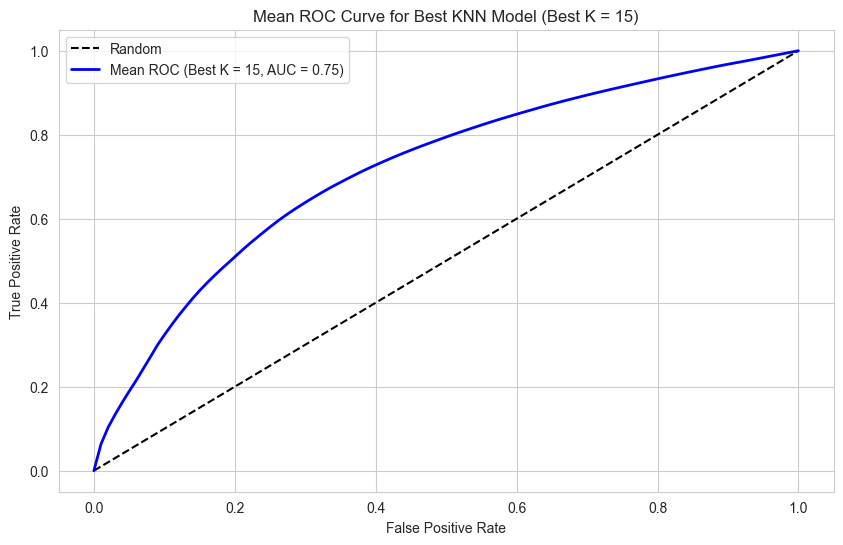

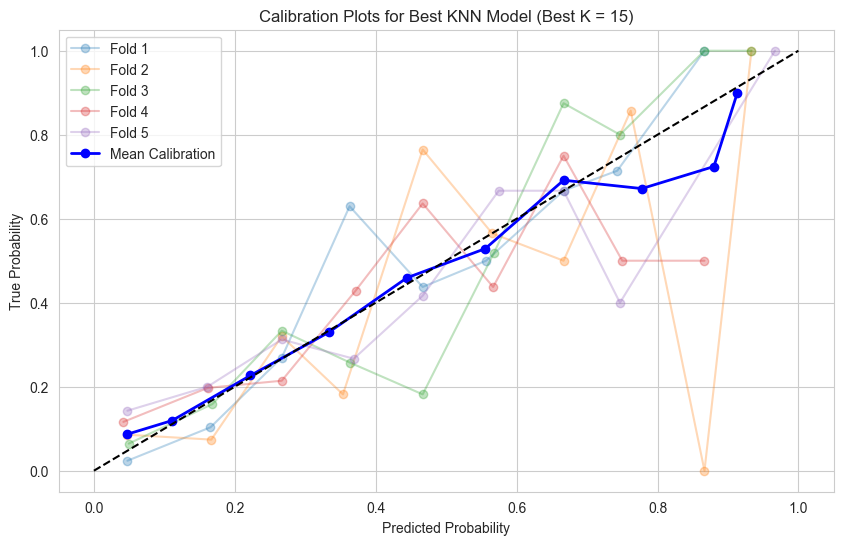


Final Best K: 15
Mean ROC-AUC: 0.7539


In [17]:
# Define the variables
X = df[['age', 'term_months', 'annual_income', 'loan_amount', 'interest_rate', 
        'credit_score', 'employment_length', 'dti']]  # Features
y = df['default']  # Set default as the target variable

# Scale the features for KNN (important for distance-based models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize cross-validation (5-fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

accuracies = []
roc_aucs = []

# For mean ROC
mean_fpr = np.linspace(0, 1, 100)
tpr_list = []

# For calibration (to store calibration for the best K)
calibration_true_best_k = []
calibration_pred_best_k = []

# K values to test
k_values = range(1, 21)  # Try K values from 1 to 20
best_k = None
best_roc_auc = -1
best_accuracy = -1

# Start loop for fine-tuning K
for k in k_values:
    print(f"Evaluating K = {k}...")
    
    # Initialize K-Nearest Neighbors model with current K
    knn_model = KNeighborsClassifier(n_neighbors=k)

    fold_accuracies = []
    fold_roc_aucs = []

    # Start CV loop for each fold
    for fold, (train_idx, test_idx) in enumerate(cv.split(X_scaled, y)):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train the K-Nearest Neighbors model
        knn_model.fit(X_train, y_train)

        # Make predictions
        y_pred = knn_model.predict(X_test)
        y_prob = knn_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

        # Calculate accuracy and ROC-AUC
        acc = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)
        fold_accuracies.append(acc)
        fold_roc_aucs.append(roc_auc)

        # ROC curve for each fold
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tpr_list.append(tpr_interp)

        # Calibration only for the best K (update below)
        if k == best_k:
            prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')
            calibration_true_best_k.append(prob_true)
            calibration_pred_best_k.append(prob_pred)

    # Compute average accuracy and ROC-AUC for the current K
    mean_acc = np.mean(fold_accuracies)
    mean_roc_auc = np.mean(fold_roc_aucs)

    print(f"K = {k} -> Mean Accuracy: {mean_acc:.4f}, Mean ROC-AUC: {mean_roc_auc:.4f}")

    # Update the best K based on the highest ROC-AUC
    if mean_roc_auc > best_roc_auc:
        best_roc_auc = mean_roc_auc
        best_accuracy = mean_acc
        best_k = k

# After determining the best K, extract the calibration data for that K
for fold, (train_idx, test_idx) in enumerate(cv.split(X_scaled, y)):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Initialize K-Nearest Neighbors model with best K
    knn_model = KNeighborsClassifier(n_neighbors=best_k)

    # Train the model
    knn_model.fit(X_train, y_train)

    # Make predictions
    y_prob = knn_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

    # Calibration for the best K (only store this for the best K)
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')
    calibration_true_best_k.append(prob_true)
    calibration_pred_best_k.append(prob_pred)

# Summary of the best K
print(f"\nBest K: {best_k} with Mean ROC-AUC: {best_roc_auc:.4f}")
print(f"Mean Accuracy for Best K = {best_k}: {best_accuracy:.4f}")

# Plot Mean ROC for the best K
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
mean_tpr_best_k = np.mean(tpr_list, axis=0)

plt.plot(mean_fpr, mean_tpr_best_k, color='blue', label=f'Mean ROC (Best K = {best_k}, AUC = {best_roc_auc:.2f})', lw=2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Mean ROC Curve for Best KNN Model (Best K = {best_k})")
plt.legend()
plt.grid(True)
plt.show()

# Plot Calibration for the best K
plt.figure(figsize=(10, 6))
for fold, (true_vals, pred_vals) in enumerate(zip(calibration_true_best_k, calibration_pred_best_k)):
    plt.plot(pred_vals, true_vals, marker='o', alpha=0.3, label=f'Fold {fold+1}')

# Mean calibration for the best K
mean_cal_pred = np.mean([np.interp(np.linspace(0, 1, 10), cp, cp) for cp in calibration_pred_best_k], axis=0)
mean_cal_true = np.mean([np.interp(np.linspace(0, 1, 10), cp, ct) for cp, ct in zip(calibration_pred_best_k, calibration_true_best_k)], axis=0)
plt.plot(mean_cal_pred, mean_cal_true, marker='o', color='blue', label='Mean Calibration', lw=2)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title(f"Calibration Plots for Best KNN Model (Best K = {best_k})")
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Final Summary
print(f"\nFinal Best K: {best_k}")
print(f"Mean ROC-AUC: {best_roc_auc:.4f}")

The **K-Nearest Neighbors (KNN) model** for loan default risk prediction shows *moderate performance* with a mean **ROC-AUC score of 0.7539** and an **accuracy of 0.7520**. These metrics indicate that the model has *reasonable discriminatory ability*, correctly identifying about **three-quarters of cases**, making it a solid baseline due to its **simplicity and interpretability**.

The **ROC curve** confirms that the model performs *better than random guessing*, demonstrating meaningful discriminatory power while balancing **true and false positives**. However, performance improvements might be possible through *more sophisticated algorithms* like **logistic regression**, **random forest**, or **gradient boosting**, which typically excel with structured financial data.

The **calibration curve** shows reasonably aligned predicted probabilities in *mid-ranges* but reveals *variance across validation folds*, particularly at **higher probability values** where default risk tends to be **overestimated**. This suggests that while the model may estimate *moderate risks accurately*, it has **limitations when predicting cases with high default probabilities**.